## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_conv04']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 'Uw',
                 'day_of_year', 'time_of_day',  
                 'buoyancy', 'diffusivity', 'temp_initial00', 
                'temp_heat01', 'temp_diff02', 'temp_total05',
                'ice', 'snow', 'snowice']
m0_output_columns =['temp_conv04']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/direct_model_train_time.pth"
m0_layers = [len(m0_input_columns), 32, 32,32,32,32,32,32,32,32,32, len(m0_output_columns)]

direct_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
direct_model.load_state_dict(m0_checkpoint)
direct_model = direct_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

## Mixing Model

# Convection Model

# Ice Model

In [9]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [10]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [11]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [12]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [13]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [14]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [15]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [16]:
def get_rollout_predictions(direct_model, loader, plot = True):    
    direct_model.eval()

    mean = torch.tensor(train_mean[m0_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m0_output_column_ix]).float().to(device)


#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        y_true = x[:, m0_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m0_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [17]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [18]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.011512252
RMSE of after m0 0.052255746
RMSE of after m0 0.03278068
RMSE of after m0 0.014023994
RMSE of after m0 0.013850591
RMSE of after m0 0.014166025
RMSE of after m0 0.013289089
RMSE of after m0 0.013248466
RMSE of after m0 0.013504157
RMSE of after m0 0.013061308
RMSE of after m0 0.013714504
RMSE of after m0 0.016008234
RMSE of after m0 0.013666918
RMSE of after m0 0.013311305
RMSE of after m0 0.0152135445
RMSE of after m0 0.016050458
RMSE of after m0 0.014071535
RMSE of after m0 0.012692198
RMSE of after m0 0.014585136
RMSE of after m0 0.0145391235
RMSE of after m0 0.014289534
RMSE of after m0 0.01636267
RMSE of after m0 0.015218807
RMSE of after m0 0.015187568
RMSE of after m0 0.01312945
RMSE of after m0 0.013103348
RMSE of after m0 0.015433803
RMSE of after m0 0.015419529
RMSE of after m0 0.01636357
RMSE of after m0 0.01527565
RMSE of after m0 0.013766097
RMSE of after m0 0.01431224
RMSE of after m0 0.01440721
RMSE of after m0 0.015142415
RMSE of after m0 0.

RMSE of after m0 0.0082792435
RMSE of after m0 0.013333899
RMSE of after m0 0.01049882
RMSE of after m0 0.008762163
RMSE of after m0 0.0089827785
RMSE of after m0 0.008131599
RMSE of after m0 0.010032509
RMSE of after m0 0.008223465
RMSE of after m0 0.008071015
RMSE of after m0 0.008564774
RMSE of after m0 0.008275129
RMSE of after m0 0.0098085515
RMSE of after m0 0.01601421
RMSE of after m0 0.013240058
RMSE of after m0 0.022173788
RMSE of after m0 0.025267828
RMSE of after m0 0.01306855
RMSE of after m0 0.016324399
RMSE of after m0 0.019841138
RMSE of after m0 0.009036704
RMSE of after m0 0.022472091
RMSE of after m0 0.01929186
RMSE of after m0 0.012684079
RMSE of after m0 0.01172741
RMSE of after m0 0.012493016
RMSE of after m0 0.009402024
RMSE of after m0 0.022881687
RMSE of after m0 0.0292289
RMSE of after m0 0.01691741
RMSE of after m0 0.015980016
RMSE of after m0 0.013115703
RMSE of after m0 0.017906114
RMSE of after m0 0.018297018
RMSE of after m0 0.01863039
RMSE of after m0 0.0

RMSE of after m0 0.017765494
RMSE of after m0 0.018279107
RMSE of after m0 0.018273262
RMSE of after m0 0.019581832
RMSE of after m0 0.01776695
RMSE of after m0 0.01995161
RMSE of after m0 0.01857867
RMSE of after m0 0.023048386
RMSE of after m0 0.006543033
RMSE of after m0 0.0071823685
RMSE of after m0 0.013781055
RMSE of after m0 0.01157701
RMSE of after m0 0.0060360087
RMSE of after m0 0.0057971184
RMSE of after m0 0.0064890026
RMSE of after m0 0.007963419
RMSE of after m0 0.008645325
RMSE of after m0 0.00803535
RMSE of after m0 0.007815442
RMSE of after m0 0.0056131245
RMSE of after m0 0.015135119
RMSE of after m0 0.030991776
RMSE of after m0 0.018231306
RMSE of after m0 0.033386055
RMSE of after m0 0.008094524
RMSE of after m0 0.0056135873
RMSE of after m0 0.0054859472
RMSE of after m0 0.005831869
RMSE of after m0 0.0054198313
RMSE of after m0 0.00812265
RMSE of after m0 0.009501545
RMSE of after m0 0.006909731
RMSE of after m0 0.0077098296
RMSE of after m0 0.0074785114
RMSE of af

RMSE of after m0 0.011209232
RMSE of after m0 0.0138165485
RMSE of after m0 0.014152497
RMSE of after m0 0.014185503
RMSE of after m0 0.0148736
RMSE of after m0 0.0138280615
RMSE of after m0 0.018554365
RMSE of after m0 0.018828003
RMSE of after m0 0.014412031
RMSE of after m0 0.012411298
RMSE of after m0 0.012395853
RMSE of after m0 0.012140905
RMSE of after m0 0.014551473
RMSE of after m0 0.01415971
RMSE of after m0 0.0148327155
RMSE of after m0 0.013276396
RMSE of after m0 0.012933261
RMSE of after m0 0.015068425
RMSE of after m0 0.015178501
RMSE of after m0 0.01472821
RMSE of after m0 0.015290173
RMSE of after m0 0.013172935
RMSE of after m0 0.01475942
RMSE of after m0 0.013655539
RMSE of after m0 0.015144327
RMSE of after m0 0.014900954
RMSE of after m0 0.016720498
RMSE of after m0 0.016616395
RMSE of after m0 0.016607042
RMSE of after m0 0.016747557
RMSE of after m0 0.015743287
RMSE of after m0 0.018530633
RMSE of after m0 0.018524451
RMSE of after m0 0.015561257
RMSE of after m0

RMSE of after m0 0.008555047
RMSE of after m0 0.016702829
RMSE of after m0 0.013506361
RMSE of after m0 0.017721646
RMSE of after m0 0.009050488
RMSE of after m0 0.008200029
RMSE of after m0 0.008821257
RMSE of after m0 0.024770554
RMSE of after m0 0.021938182
RMSE of after m0 0.01682203
RMSE of after m0 0.014217854
RMSE of after m0 0.0078563355
RMSE of after m0 0.011718463
RMSE of after m0 0.0108604105
RMSE of after m0 0.012158198
RMSE of after m0 0.009358546
RMSE of after m0 0.009264373
RMSE of after m0 0.009108486
RMSE of after m0 0.0078042997
RMSE of after m0 0.0067023765
RMSE of after m0 0.014803587
RMSE of after m0 0.009876362
RMSE of after m0 0.008672777
RMSE of after m0 0.007124428
RMSE of after m0 0.0064433366
RMSE of after m0 0.0065007466
RMSE of after m0 0.0063590435
RMSE of after m0 0.0065000607
RMSE of after m0 0.0062721325
RMSE of after m0 0.007038529
RMSE of after m0 0.017330931
RMSE of after m0 0.009219394
RMSE of after m0 0.007112714
RMSE of after m0 0.008451449
RMSE o

RMSE of after m0 0.0106028225
RMSE of after m0 0.0052938806
RMSE of after m0 0.007851361
RMSE of after m0 0.009426809
RMSE of after m0 0.009816549
RMSE of after m0 0.008276302
RMSE of after m0 0.025439164
RMSE of after m0 0.013248897
RMSE of after m0 0.016041936
RMSE of after m0 0.0069526387
RMSE of after m0 0.0080330605
RMSE of after m0 0.0082884375
RMSE of after m0 0.0051320433
RMSE of after m0 0.00903278
RMSE of after m0 0.009890228
RMSE of after m0 0.008795007
RMSE of after m0 0.006938946
RMSE of after m0 0.006999796
RMSE of after m0 0.0071274517
RMSE of after m0 0.006514897
RMSE of after m0 0.018022384
RMSE of after m0 0.017270844
RMSE of after m0 0.011512853
RMSE of after m0 0.011626109
RMSE of after m0 0.0076563065
RMSE of after m0 0.008008807
RMSE of after m0 0.00781361
RMSE of after m0 0.010703306
RMSE of after m0 0.009806485
RMSE of after m0 0.009470345
RMSE of after m0 0.0068809716
RMSE of after m0 0.0073828828
RMSE of after m0 0.0065665008
RMSE of after m0 0.0077785123
RMSE

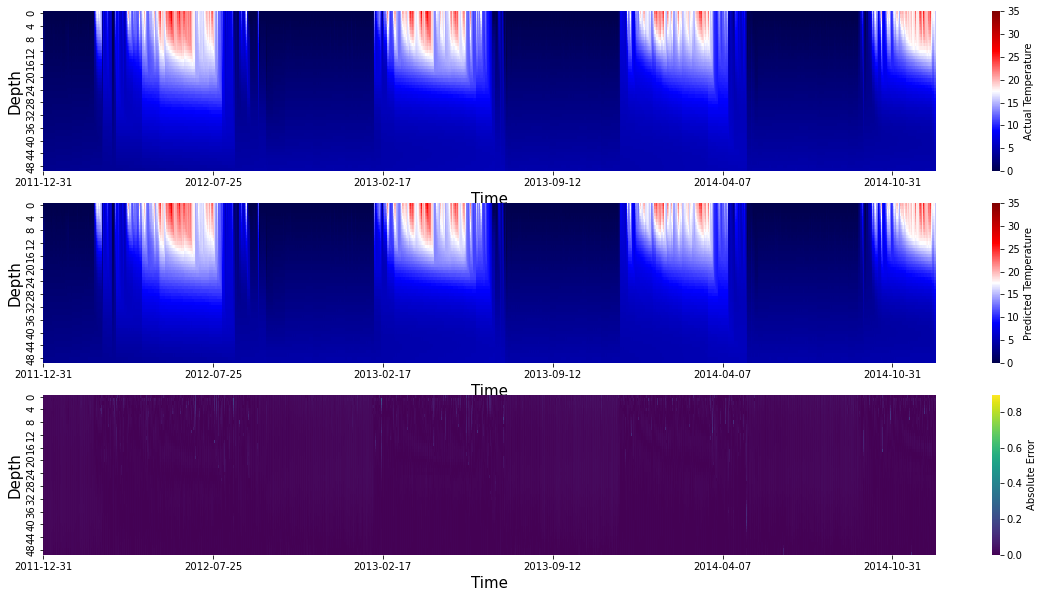

In [19]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

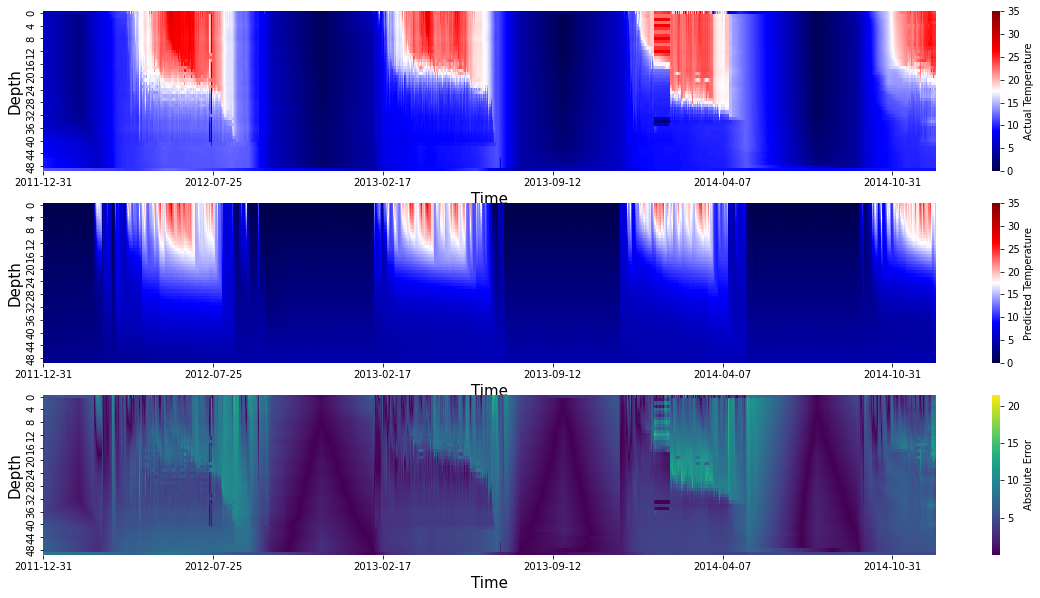

In [20]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [21]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.006775576
RMSE of after m0 0.006456804
RMSE of after m0 0.0072900676
RMSE of after m0 0.0075830985
RMSE of after m0 0.0074228453
RMSE of after m0 0.0076671233
RMSE of after m0 0.009064886
RMSE of after m0 0.011831956
RMSE of after m0 0.010758576
RMSE of after m0 0.0065710284
RMSE of after m0 0.006844323
RMSE of after m0 0.00793829
RMSE of after m0 0.008027544
RMSE of after m0 0.008686456
RMSE of after m0 0.008545842
RMSE of after m0 0.007622324
RMSE of after m0 0.008080294
RMSE of after m0 0.009953266
RMSE of after m0 0.008835508
RMSE of after m0 0.0076844483
RMSE of after m0 0.006756215
RMSE of after m0 0.014371104
RMSE of after m0 0.010970992
RMSE of after m0 0.0058297664
RMSE of after m0 0.0068972167
RMSE of after m0 0.008276818
RMSE of after m0 0.0066968133
RMSE of after m0 0.008758224
RMSE of after m0 0.008109601
RMSE of after m0 0.008298328
RMSE of after m0 0.007730686
RMSE of after m0 0.008913384
RMSE of after m0 0.008951262
RMSE of after m0 0.009365394
RMSE o

RMSE of after m0 0.009998045
RMSE of after m0 0.017571634
RMSE of after m0 0.014144769
RMSE of after m0 0.015958138
RMSE of after m0 0.01036956
RMSE of after m0 0.008836104
RMSE of after m0 0.011911002
RMSE of after m0 0.009960766
RMSE of after m0 0.010602834
RMSE of after m0 0.009895456
RMSE of after m0 0.010148676
RMSE of after m0 0.009112573
RMSE of after m0 0.010932259
RMSE of after m0 0.01041587
RMSE of after m0 0.0070684184
RMSE of after m0 0.00835402
RMSE of after m0 0.008517677
RMSE of after m0 0.00901844
RMSE of after m0 0.00972388
RMSE of after m0 0.04315815
RMSE of after m0 0.034447
RMSE of after m0 0.01880154
RMSE of after m0 0.027817389
RMSE of after m0 0.021166833
RMSE of after m0 0.016620524
RMSE of after m0 0.0067939064
RMSE of after m0 0.0075018476
RMSE of after m0 0.015620859
RMSE of after m0 0.0111785
RMSE of after m0 0.01604786
RMSE of after m0 0.012629955
RMSE of after m0 0.009516075
RMSE of after m0 0.02405454
RMSE of after m0 0.010062043
RMSE of after m0 0.007823

RMSE of after m0 0.013840983
RMSE of after m0 0.0124344705
RMSE of after m0 0.010729816
RMSE of after m0 0.009878964
RMSE of after m0 0.01043229
RMSE of after m0 0.010431878
RMSE of after m0 0.011504435
RMSE of after m0 0.01051756
RMSE of after m0 0.013700741
RMSE of after m0 0.012307279
RMSE of after m0 0.010654477
RMSE of after m0 0.010913322
RMSE of after m0 0.011528694
RMSE of after m0 0.009395139
RMSE of after m0 0.008749206
RMSE of after m0 0.009484507
RMSE of after m0 0.011082085
RMSE of after m0 0.011078585
RMSE of after m0 0.011952513
RMSE of after m0 0.011672855
RMSE of after m0 0.011866466
RMSE of after m0 0.011408373
RMSE of after m0 0.01055754
RMSE of after m0 0.010335515
RMSE of after m0 0.011615814
RMSE of after m0 0.011639745
RMSE of after m0 0.010644167
RMSE of after m0 0.009564507
RMSE of after m0 0.01091282
RMSE of after m0 0.009741546
RMSE of after m0 0.012075509
RMSE of after m0 0.0125112245
RMSE of after m0 0.010758518
RMSE of after m0 0.008715693
RMSE of after m0

RMSE of after m0 0.008852429
RMSE of after m0 0.008906574
RMSE of after m0 0.008681835
RMSE of after m0 0.011070224
RMSE of after m0 0.009052839
RMSE of after m0 0.0131329205
RMSE of after m0 0.019074382
RMSE of after m0 0.01885329
RMSE of after m0 0.0114824055
RMSE of after m0 0.008722634
RMSE of after m0 0.012104322
RMSE of after m0 0.010709411
RMSE of after m0 0.01041932
RMSE of after m0 0.010387157
RMSE of after m0 0.010092387
RMSE of after m0 0.010550502
RMSE of after m0 0.009249826
RMSE of after m0 0.009690943
RMSE of after m0 0.0167831
RMSE of after m0 0.028564926
RMSE of after m0 0.010391422
RMSE of after m0 0.006624805
RMSE of after m0 0.0066653662
RMSE of after m0 0.008033559
RMSE of after m0 0.0074447636
RMSE of after m0 0.009240219
RMSE of after m0 0.0083949845
RMSE of after m0 0.0076541356
RMSE of after m0 0.008611847
RMSE of after m0 0.008496746
RMSE of after m0 0.008087619
RMSE of after m0 0.007949112
RMSE of after m0 0.010175695
RMSE of after m0 0.010960048
RMSE of afte

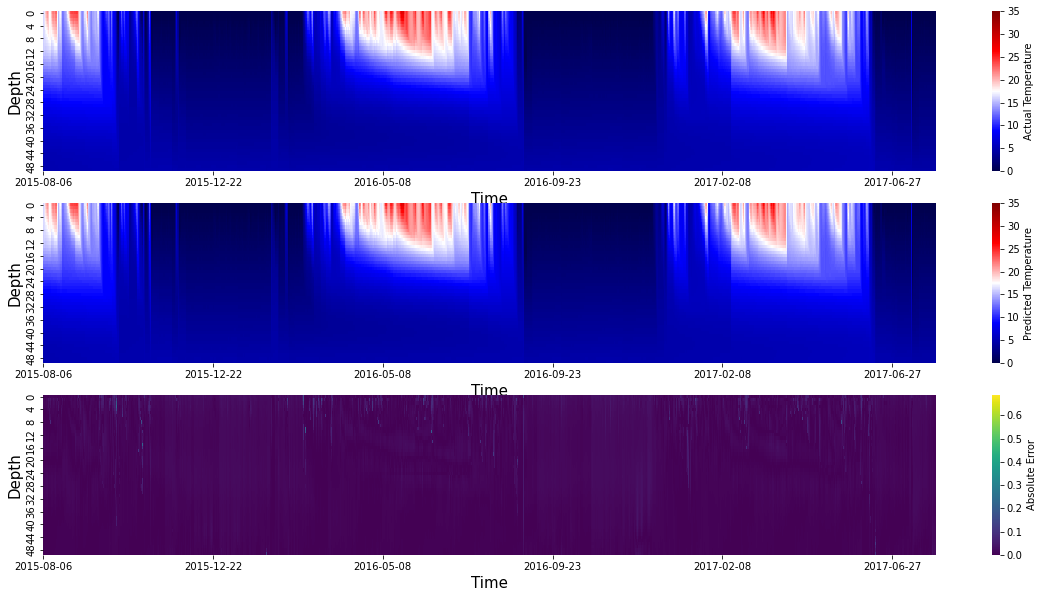

In [22]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

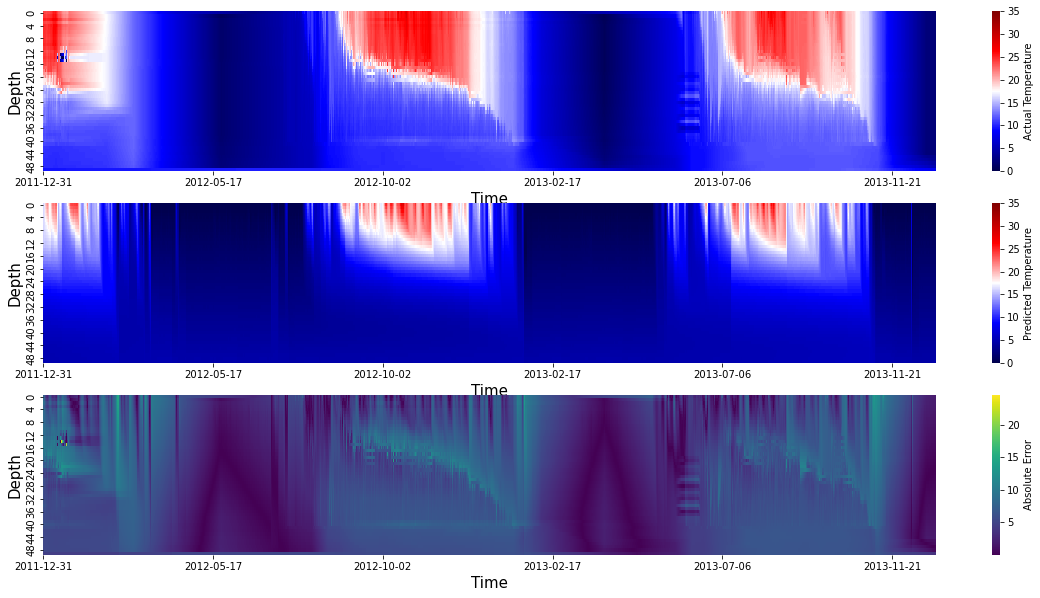

In [23]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [24]:
train_rmse, train_l2_err = compute_metrics( direct_model, train_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(direct_model, test_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.013291250906529615, Train L2 Error: 0.001750358174506588
Test RMSE: 0.012914304745543781, Train L2 Error: 0.0016236128994622687


## Mixing Model

## Convection Model

## Ice Model

# Finetuning

In [25]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(direct_model.parameters()) 
optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [26]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [27]:
#freeze_model(heating_model)

unfreeze_model(direct_model)


# Finetuning on Observed Temperature

In [ ]:
direct_model.train()


n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out0 = torch.tensor(train_mean[m0_output_column_ix[0]]).float().to(device)
std_out0 = torch.tensor(train_std[m0_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input

train_loss = []
LOSS_m0 = []


for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0

    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out0)/std_out0
        
        loss_m0 = criterion(m0_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m0
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()

    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)

    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)

    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:24<6:55:57, 24.98s/it]

Epoch : 0, Train_loss: 0.683488121747862, Loss m0: 0.683488121747862


  5%|▌         | 51/1000 [20:32<6:31:20, 24.74s/it]

Epoch : 50, Train_loss: 0.14091330816246586, Loss m0: 0.14091330816246586


 10%|█         | 101/1000 [36:17<4:36:51, 18.48s/it]

Epoch : 100, Train_loss: 0.11813751182590312, Loss m0: 0.11813751182590312


 15%|█▌        | 151/1000 [51:42<4:21:46, 18.50s/it]

Epoch : 150, Train_loss: 0.10368133324464897, Loss m0: 0.10368133324464897


 20%|██        | 201/1000 [1:07:07<4:06:04, 18.48s/it]

Epoch : 200, Train_loss: 0.09243808447085887, Loss m0: 0.09243808447085887


 25%|██▌       | 251/1000 [1:22:07<3:44:21, 17.97s/it]

Epoch : 250, Train_loss: 0.08483753892497475, Loss m0: 0.08483753892497475


 30%|███       | 301/1000 [1:37:05<3:28:48, 17.92s/it]

Epoch : 300, Train_loss: 0.08035472773354269, Loss m0: 0.08035472773354269


 35%|███▌      | 351/1000 [1:52:04<3:13:59, 17.94s/it]

Epoch : 350, Train_loss: 0.07682111150678365, Loss m0: 0.07682111150678365


 40%|████      | 401/1000 [2:07:03<2:59:01, 17.93s/it]

Epoch : 400, Train_loss: 0.0730499795412129, Loss m0: 0.0730499795412129


 45%|████▌     | 451/1000 [2:22:09<2:46:23, 18.19s/it]

Epoch : 450, Train_loss: 0.06899919897817779, Loss m0: 0.06899919897817779


 50%|█████     | 501/1000 [2:37:23<2:30:59, 18.16s/it]

Epoch : 500, Train_loss: 0.06426226161339194, Loss m0: 0.06426226161339194


 55%|█████▌    | 551/1000 [2:52:34<2:16:02, 18.18s/it]

Epoch : 550, Train_loss: 0.05881261022745824, Loss m0: 0.05881261022745824


 60%|██████    | 601/1000 [3:07:43<2:00:56, 18.19s/it]

Epoch : 600, Train_loss: 0.05502396988288053, Loss m0: 0.05502396988288053


 65%|██████▌   | 651/1000 [3:22:46<1:44:11, 17.91s/it]

Epoch : 650, Train_loss: 0.052303577015798776, Loss m0: 0.052303577015798776


 70%|███████   | 701/1000 [3:37:43<1:29:19, 17.92s/it]

Epoch : 700, Train_loss: 0.05072223539532786, Loss m0: 0.05072223539532786


 75%|███████▌  | 751/1000 [3:52:44<1:15:18, 18.15s/it]

Epoch : 750, Train_loss: 0.049633567311098095, Loss m0: 0.049633567311098095


 77%|███████▋  | 768/1000 [3:57:58<1:14:53, 19.37s/it]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")

plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [ ]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [ ]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

In [ ]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Mixing Model

## Convection Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Ice Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

# Compute Model Similarity after Finetuning

In [ ]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [ ]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
# Freeze all models again and compute finetuned diffusivity values

In [ ]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [ ]:
#PATH = f"./saved_models/diffusion_model_finetuned.pth"
#torch.save(heat_diff_model.state_dict(), PATH)